In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from prophet import Prophet
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation, performance_metrics

from sklearn.metrics import mean_absolute_error

from itertools import product

import warnings
warnings.filterwarnings('ignore')

In [29]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

Predict the monthly average price of steak in Canada.
Dataset used: historically monthly prices of food in Canada. Contains 52 goods but we just need stake product

In [30]:
df = pd.read_csv('/Users/irene/Library/CloudStorage/OneDrive-Personal/public/forecast/data/monthly_avg_retail_price_food_canada.csv')
print(df.head())
print(df.shape)

  REF_DATE     GEO           DGUID                 Products      UOM  UOM_ID  \
0  1995-01  Canada  2016A000011124  Round steak, 1 kilogram  Dollars      81   
1  1995-02  Canada  2016A000011124  Round steak, 1 kilogram  Dollars      81   
2  1995-03  Canada  2016A000011124  Round steak, 1 kilogram  Dollars      81   
3  1995-04  Canada  2016A000011124  Round steak, 1 kilogram  Dollars      81   
4  1995-05  Canada  2016A000011124  Round steak, 1 kilogram  Dollars      81   

  SCALAR_FACTOR  SCALAR_ID   VECTOR  COORDINATE  VALUE  STATUS  SYMBOL  \
0         units          0  v735165         1.1  10.17     NaN     NaN   
1         units          0  v735165         1.1  10.29     NaN     NaN   
2         units          0  v735165         1.1  10.12     NaN     NaN   
3         units          0  v735165         1.1  10.38     NaN     NaN   
4         units          0  v735165         1.1  10.00     NaN     NaN   

   TERMINATED  DECIMALS  
0         NaN         2  
1         NaN         

In [31]:
df = df[df['Products'] == 'Round steak, 1 kilogram'] # filter for Round steak, 1 kilogram as we just are interested in this product
df.head()

,REF_DATE,GEO,DGUID,Products,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,1995-01,Canada,2016A000011124,"Round steak, 1 kilogram",Dollars,81,units,0,v735165,1.1,10.17,NaN,NaN,NaN,2
1,1995-02,Canada,2016A000011124,"Round steak, 1 kilogram",Dollars,81,units,0,v735165,1.1,10.29,NaN,NaN,NaN,2
2,1995-03,Canada,2016A000011124,"Round steak, 1 kilogram",Dollars,81,units,0,v735165,1.1,10.12,NaN,NaN,NaN,2
3,1995-04,Canada,2016A000011124,"Round steak, 1 kilogram",Dollars,81,units,0,v735165,1.1,10.38,NaN,NaN,NaN,2
4,1995-05,Canada,2016A000011124,"Round steak, 1 kilogram",Dollars,81,units,0,v735165,1.1,10.00,NaN,NaN,NaN,2


In [32]:
# see the columns
df.columns

Index(['REF_DATE', 'GEO', 'DGUID', 'Products', 'UOM', 'UOM_ID',
       'SCALAR_FACTOR', 'SCALAR_ID', 'VECTOR', 'COORDINATE', 'VALUE', 'STATUS',
       'SYMBOL', 'TERMINATED', 'DECIMALS'],
      dtype='object')

In [33]:
# remove the columns not needed, all except the date and the price
df = df[['REF_DATE', 'VALUE']]
df.shape

(323, 2)

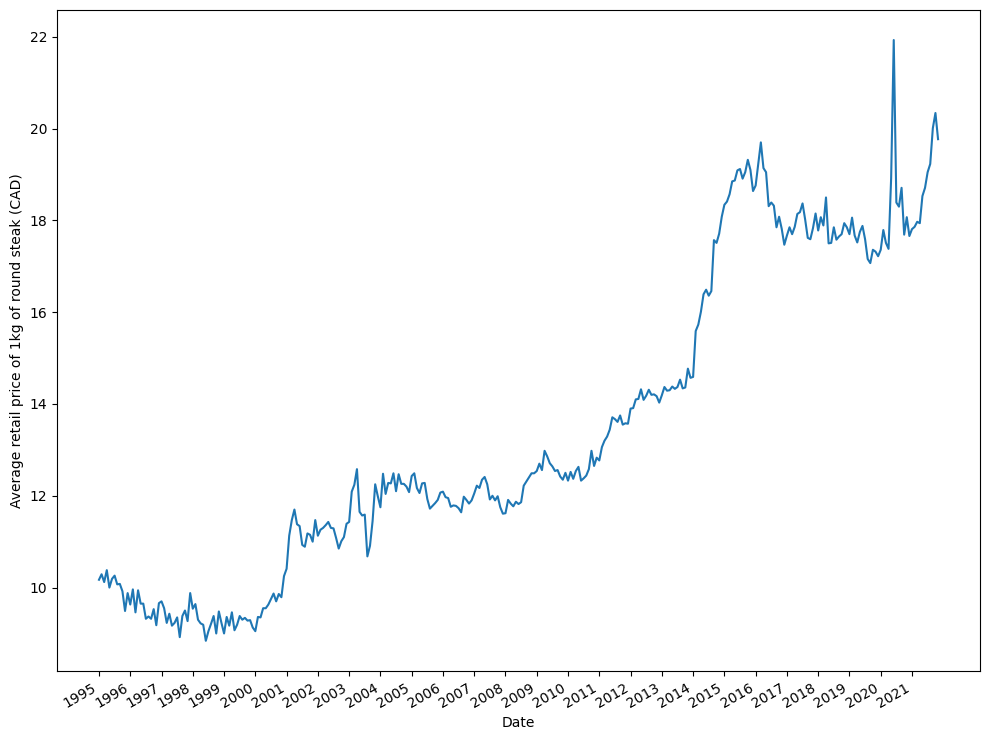

In [34]:
fig, ax = plt.subplots()

ax.plot(df['VALUE'])
ax.set_xlabel('Date')
ax.set_ylabel('Average retail price of 1kg of round steak (CAD)')

plt.xticks(np.arange(0, 322, 12), np.arange(1995, 2022, 1))

fig.autofmt_xdate()
plt.tight_layout()
 

doesnt seem to be seasonality here, if so, Phophet might not be ideal

In [35]:
# rename the columns to ds and y for Prophet model
df.columns = ['ds', 'y']
df.head()

,ds,y
0,1995-01,10.17
1,1995-02,10.29
2,1995-03,10.12
3,1995-04,10.38
4,1995-05,10.00


In [36]:
# format the date column using the end of the month date, as we are working with monthly data
from pandas.tseries.offsets import MonthEnd

df['ds'] = pd.to_datetime(df['ds']) + MonthEnd(1)


In [37]:
# splt the data into train and test: as our objective is forecast 36 months ahead, we will use the last 36 months as test
train = df.iloc[:-36]
test = df.iloc[-36:]


Hyperparameter tuning  
defining a list of possible changepoint_prior_scale and seasonality_prior_scale values to test. We wont see any holidays .
We will create a list of all possible combinations of these values using and calculate the MSE as a selection criterion, as penalizes lage errors

In [38]:
param_grid = {
    'changepoint_prior_scale': [0.01, 0.1, 1.0],
    'seasonality_prior_scale': [0.1, 1.0, 10.0]
}

params = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]

mses = []

In [39]:
#cutoffs = pd.date_range(start='2000-01-31', end='2018-11-30', freq='36M')
#cutoffs

In [40]:
for param in params:
    m = Prophet(**param)
    m.fit(train)
    
    # Perform cross-validation automatically based on `initial` and `period`
    df_cv = cross_validation(model=m, horizon='365 days', period='180 days', initial='730 days')
    df_p = performance_metrics(df_cv, rolling_window=1)
    mses.append(df_p['mse'].values[0])


10:41:21 - cmdstanpy - INFO - Chain [1] start processing
10:41:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/43 [00:00<?, ?it/s]

10:41:21 - cmdstanpy - INFO - Chain [1] start processing
10:41:22 - cmdstanpy - INFO - Chain [1] done processing
10:41:22 - cmdstanpy - INFO - Chain [1] start processing
10:41:22 - cmdstanpy - INFO - Chain [1] done processing
10:41:22 - cmdstanpy - INFO - Chain [1] start processing
10:41:22 - cmdstanpy - INFO - Chain [1] done processing
10:41:22 - cmdstanpy - INFO - Chain [1] start processing
10:41:22 - cmdstanpy - INFO - Chain [1] done processing
10:41:22 - cmdstanpy - INFO - Chain [1] start processing
10:41:22 - cmdstanpy - INFO - Chain [1] done processing
10:41:22 - cmdstanpy - INFO - Chain [1] start processing
10:41:22 - cmdstanpy - INFO - Chain [1] done processing
10:41:22 - cmdstanpy - INFO - Chain [1] start processing
10:41:22 - cmdstanpy - INFO - Chain [1] done processing
10:41:22 - cmdstanpy - INFO - Chain [1] start processing
10:41:23 - cmdstanpy - INFO - Chain [1] done processing
10:41:23 - cmdstanpy - INFO - Chain [1] start processing
10:41:23 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/43 [00:00<?, ?it/s]

10:41:25 - cmdstanpy - INFO - Chain [1] start processing
10:41:25 - cmdstanpy - INFO - Chain [1] done processing
10:41:25 - cmdstanpy - INFO - Chain [1] start processing
10:41:25 - cmdstanpy - INFO - Chain [1] done processing
10:41:25 - cmdstanpy - INFO - Chain [1] start processing
10:41:25 - cmdstanpy - INFO - Chain [1] done processing
10:41:25 - cmdstanpy - INFO - Chain [1] start processing
10:41:26 - cmdstanpy - INFO - Chain [1] done processing
10:41:26 - cmdstanpy - INFO - Chain [1] start processing
10:41:26 - cmdstanpy - INFO - Chain [1] done processing
10:41:26 - cmdstanpy - INFO - Chain [1] start processing
10:41:26 - cmdstanpy - INFO - Chain [1] done processing
10:41:26 - cmdstanpy - INFO - Chain [1] start processing
10:41:26 - cmdstanpy - INFO - Chain [1] done processing
10:41:26 - cmdstanpy - INFO - Chain [1] start processing
10:41:26 - cmdstanpy - INFO - Chain [1] done processing
10:41:26 - cmdstanpy - INFO - Chain [1] start processing
10:41:26 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/43 [00:00<?, ?it/s]

10:41:28 - cmdstanpy - INFO - Chain [1] start processing
10:41:29 - cmdstanpy - INFO - Chain [1] done processing
10:41:29 - cmdstanpy - INFO - Chain [1] start processing
10:41:29 - cmdstanpy - INFO - Chain [1] done processing
10:41:29 - cmdstanpy - INFO - Chain [1] start processing
10:41:29 - cmdstanpy - INFO - Chain [1] done processing
10:41:29 - cmdstanpy - INFO - Chain [1] start processing
10:41:29 - cmdstanpy - INFO - Chain [1] done processing
10:41:29 - cmdstanpy - INFO - Chain [1] start processing
10:41:29 - cmdstanpy - INFO - Chain [1] done processing
10:41:29 - cmdstanpy - INFO - Chain [1] start processing
10:41:29 - cmdstanpy - INFO - Chain [1] done processing
10:41:29 - cmdstanpy - INFO - Chain [1] start processing
10:41:29 - cmdstanpy - INFO - Chain [1] done processing
10:41:29 - cmdstanpy - INFO - Chain [1] start processing
10:41:30 - cmdstanpy - INFO - Chain [1] done processing
10:41:30 - cmdstanpy - INFO - Chain [1] start processing
10:41:30 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/43 [00:00<?, ?it/s]

10:41:32 - cmdstanpy - INFO - Chain [1] start processing
10:41:40 - cmdstanpy - INFO - Chain [1] done processing
10:41:40 - cmdstanpy - INFO - Chain [1] start processing
10:41:40 - cmdstanpy - INFO - Chain [1] done processing
10:41:40 - cmdstanpy - INFO - Chain [1] start processing
10:41:40 - cmdstanpy - INFO - Chain [1] done processing
10:41:40 - cmdstanpy - INFO - Chain [1] start processing
10:41:40 - cmdstanpy - INFO - Chain [1] done processing
10:41:40 - cmdstanpy - INFO - Chain [1] start processing
10:41:40 - cmdstanpy - INFO - Chain [1] done processing
10:41:40 - cmdstanpy - INFO - Chain [1] start processing
10:41:41 - cmdstanpy - INFO - Chain [1] done processing
10:41:41 - cmdstanpy - INFO - Chain [1] start processing
10:41:41 - cmdstanpy - INFO - Chain [1] done processing
10:41:41 - cmdstanpy - INFO - Chain [1] start processing
10:41:41 - cmdstanpy - INFO - Chain [1] done processing
10:41:41 - cmdstanpy - INFO - Chain [1] start processing
10:41:41 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/43 [00:00<?, ?it/s]

10:41:44 - cmdstanpy - INFO - Chain [1] start processing
10:41:52 - cmdstanpy - INFO - Chain [1] done processing
10:41:52 - cmdstanpy - INFO - Chain [1] start processing
10:41:53 - cmdstanpy - INFO - Chain [1] done processing
10:41:53 - cmdstanpy - INFO - Chain [1] start processing
10:41:53 - cmdstanpy - INFO - Chain [1] done processing
10:41:53 - cmdstanpy - INFO - Chain [1] start processing
10:41:53 - cmdstanpy - INFO - Chain [1] done processing
10:41:53 - cmdstanpy - INFO - Chain [1] start processing
10:41:53 - cmdstanpy - INFO - Chain [1] done processing
10:41:54 - cmdstanpy - INFO - Chain [1] start processing
10:41:54 - cmdstanpy - INFO - Chain [1] done processing
10:41:54 - cmdstanpy - INFO - Chain [1] start processing
10:41:54 - cmdstanpy - INFO - Chain [1] done processing
10:41:54 - cmdstanpy - INFO - Chain [1] start processing
10:41:54 - cmdstanpy - INFO - Chain [1] done processing
10:41:54 - cmdstanpy - INFO - Chain [1] start processing
10:41:55 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/43 [00:00<?, ?it/s]

10:41:58 - cmdstanpy - INFO - Chain [1] start processing
10:42:05 - cmdstanpy - INFO - Chain [1] done processing
10:42:05 - cmdstanpy - INFO - Chain [1] start processing
10:42:06 - cmdstanpy - INFO - Chain [1] done processing
10:42:06 - cmdstanpy - INFO - Chain [1] start processing
10:42:06 - cmdstanpy - INFO - Chain [1] done processing
10:42:06 - cmdstanpy - INFO - Chain [1] start processing
10:42:06 - cmdstanpy - INFO - Chain [1] done processing
10:42:06 - cmdstanpy - INFO - Chain [1] start processing
10:42:06 - cmdstanpy - INFO - Chain [1] done processing
10:42:06 - cmdstanpy - INFO - Chain [1] start processing
10:42:06 - cmdstanpy - INFO - Chain [1] done processing
10:42:06 - cmdstanpy - INFO - Chain [1] start processing
10:42:07 - cmdstanpy - INFO - Chain [1] done processing
10:42:07 - cmdstanpy - INFO - Chain [1] start processing
10:42:07 - cmdstanpy - INFO - Chain [1] done processing
10:42:07 - cmdstanpy - INFO - Chain [1] start processing
10:42:07 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/43 [00:00<?, ?it/s]

10:42:10 - cmdstanpy - INFO - Chain [1] start processing
10:42:18 - cmdstanpy - INFO - Chain [1] done processing
10:42:18 - cmdstanpy - INFO - Chain [1] start processing
10:42:27 - cmdstanpy - INFO - Chain [1] done processing
10:42:27 - cmdstanpy - INFO - Chain [1] start processing
10:42:38 - cmdstanpy - INFO - Chain [1] done processing
10:42:38 - cmdstanpy - INFO - Chain [1] start processing
10:42:46 - cmdstanpy - INFO - Chain [1] done processing
10:42:46 - cmdstanpy - INFO - Chain [1] start processing
10:42:46 - cmdstanpy - INFO - Chain [1] done processing
10:42:46 - cmdstanpy - INFO - Chain [1] start processing
10:42:46 - cmdstanpy - INFO - Chain [1] done processing
10:42:46 - cmdstanpy - INFO - Chain [1] start processing
10:42:46 - cmdstanpy - INFO - Chain [1] done processing
10:42:46 - cmdstanpy - INFO - Chain [1] start processing
10:42:46 - cmdstanpy - INFO - Chain [1] done processing
10:42:46 - cmdstanpy - INFO - Chain [1] start processing
10:42:47 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/43 [00:00<?, ?it/s]

10:42:50 - cmdstanpy - INFO - Chain [1] start processing
10:42:58 - cmdstanpy - INFO - Chain [1] done processing
10:42:58 - cmdstanpy - INFO - Chain [1] start processing
10:43:07 - cmdstanpy - INFO - Chain [1] done processing
10:43:07 - cmdstanpy - INFO - Chain [1] start processing
10:43:16 - cmdstanpy - INFO - Chain [1] done processing
10:43:16 - cmdstanpy - INFO - Chain [1] start processing
10:43:27 - cmdstanpy - INFO - Chain [1] done processing
10:43:27 - cmdstanpy - INFO - Chain [1] start processing
10:43:27 - cmdstanpy - INFO - Chain [1] done processing
10:43:27 - cmdstanpy - INFO - Chain [1] start processing
10:43:28 - cmdstanpy - INFO - Chain [1] done processing
10:43:28 - cmdstanpy - INFO - Chain [1] start processing
10:43:28 - cmdstanpy - INFO - Chain [1] done processing
10:43:28 - cmdstanpy - INFO - Chain [1] start processing
10:43:28 - cmdstanpy - INFO - Chain [1] done processing
10:43:28 - cmdstanpy - INFO - Chain [1] start processing
10:43:28 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/43 [00:00<?, ?it/s]

10:43:32 - cmdstanpy - INFO - Chain [1] start processing
10:43:39 - cmdstanpy - INFO - Chain [1] done processing
10:43:39 - cmdstanpy - INFO - Chain [1] start processing
10:43:44 - cmdstanpy - INFO - Chain [1] done processing
10:43:44 - cmdstanpy - INFO - Chain [1] start processing
10:43:55 - cmdstanpy - INFO - Chain [1] done processing
10:43:55 - cmdstanpy - INFO - Chain [1] start processing
10:44:06 - cmdstanpy - INFO - Chain [1] done processing
10:44:06 - cmdstanpy - INFO - Chain [1] start processing
10:44:06 - cmdstanpy - INFO - Chain [1] done processing
10:44:06 - cmdstanpy - INFO - Chain [1] start processing
10:44:06 - cmdstanpy - INFO - Chain [1] done processing
10:44:06 - cmdstanpy - INFO - Chain [1] start processing
10:44:06 - cmdstanpy - INFO - Chain [1] done processing
10:44:06 - cmdstanpy - INFO - Chain [1] start processing
10:44:07 - cmdstanpy - INFO - Chain [1] done processing
10:44:07 - cmdstanpy - INFO - Chain [1] start processing
10:44:07 - cmdstanpy - INFO - Chain [1]

In [41]:
best_params = params[np.argmin(mses)]
print(best_params)

{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0}


In [42]:
best_params = {'changepoint_prior_scale': 1.0, 'seasonality_prior_scale': 1.0}

In [43]:
m = Prophet(**best_params)
m.fit(train);

10:44:10 - cmdstanpy - INFO - Chain [1] start processing
10:44:10 - cmdstanpy - INFO - Chain [1] done processing


In [44]:
future = m.make_future_dataframe(periods=36, freq='M')

In [45]:
# forecast the future
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12)

,ds,yhat,yhat_lower,yhat_upper
311,2020-12-31,19.187118,17.292185,20.817002
312,2021-01-31,19.180562,17.158000,21.013679
313,2021-02-28,19.515795,17.515256,21.317225
314,2021-03-31,19.439979,17.365999,21.346007
315,2021-04-30,19.565146,17.349053,21.641854
316,2021-05-31,19.508936,17.135220,21.564040
317,2021-06-30,19.435151,16.980096,21.682048
318,2021-07-31,19.396704,16.863127,21.828318
319,2021-08-31,19.383425,16.552172,21.921599
320,2021-09-30,19.392970,16.501268,22.067870


In [46]:
# append to the future dataframe the test data, so we can compare the forecast with the actual values
test[['yhat', 'yhat_lower', 'yhat_upper']] = forecast[['yhat', 'yhat_lower', 'yhat_upper']]
test.head()

,ds,y,yhat,yhat_lower,yhat_upper
287,2018-12-31,17.85,18.584683,17.935642,19.296328
288,2019-01-31,17.70,18.570015,17.851429,19.223589
289,2019-02-28,18.06,18.749032,18.041584,19.446203
290,2019-03-31,17.67,18.776915,18.113963,19.460136
291,2019-04-30,17.52,19.030392,18.392298,19.706235


In [47]:
# create a baseline just based on the last value of the train data
test['Baseline'] = train['y'].iloc[-1]
test.head()

,ds,y,yhat,yhat_lower,yhat_upper,Baseline
287,2018-12-31,17.85,18.584683,17.935642,19.296328,17.94
288,2019-01-31,17.70,18.570015,17.851429,19.223589,17.94
289,2019-02-28,18.06,18.749032,18.041584,19.446203,17.94
290,2019-03-31,17.67,18.776915,18.113963,19.460136,17.94
291,2019-04-30,17.52,19.030392,18.392298,19.706235,17.94


In [48]:
# using mean absolute error to compare the forecast with the baseline
baseline_mae = mean_absolute_error(test['y'], test['Baseline'])
prophet_mae = mean_absolute_error(test['y'], test['yhat'])

print(prophet_mae)
print(baseline_mae)

1.1544369688318648
0.6816666666666671


Prophet performs much worst than baseline.

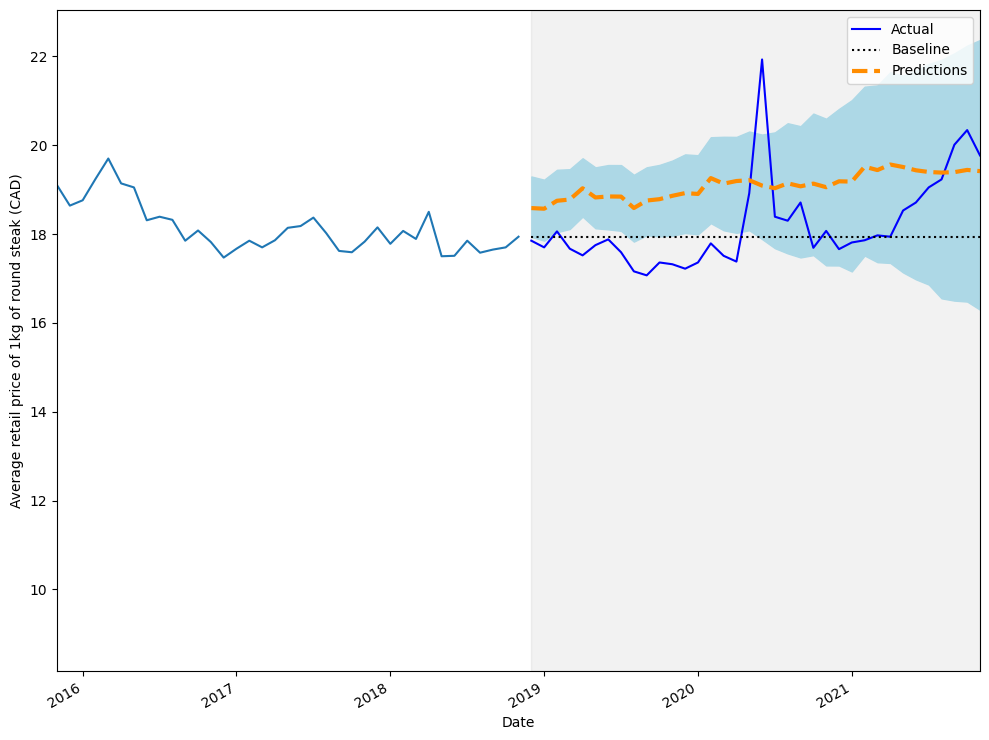

In [49]:
fig, ax = plt.subplots()

ax.plot(train['y'])
ax.plot(test['y'], 'b-', label='Actual')
ax.plot(test['Baseline'], 'k:', label='Baseline')
ax.plot(test['yhat'], color='darkorange', ls='--', lw=3, label='Predictions')

ax.set_xlabel('Date')
ax.set_ylabel('Average retail price of 1kg of round steak (CAD)')

ax.axvspan(287, 322, color='#808080', alpha=0.1)

ax.legend(loc='best')

plt.xticks(np.arange(0, 322, 12), np.arange(1995, 2022, 1))
plt.fill_between(x=test.index, y1=test['yhat_lower'], y2=test['yhat_upper'], color='lightblue')
plt.xlim(250, 322)

fig.autofmt_xdate()
plt.tight_layout()

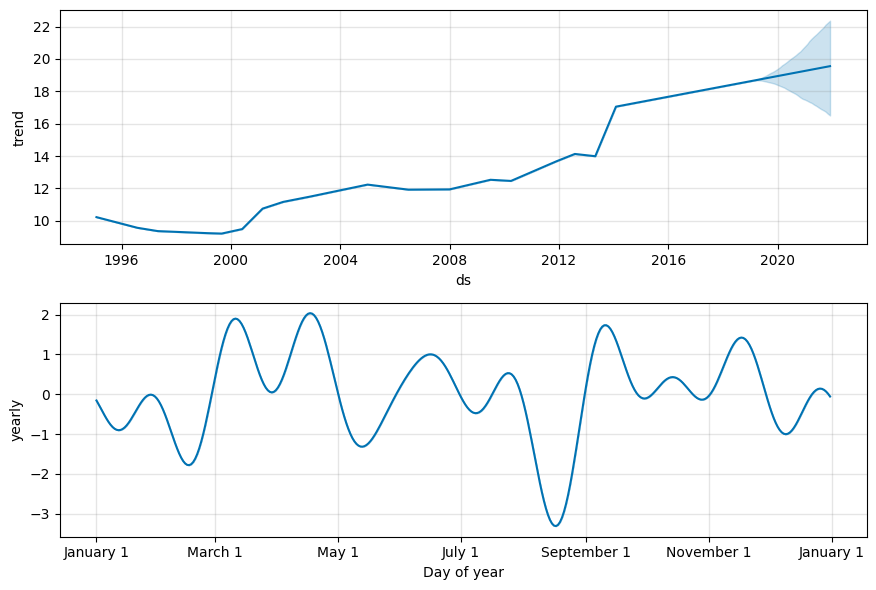

In [50]:

prophet_components_fig = m.plot_components(forecast)